# Reference tracking NMPC

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from openmpc.mpc import MPCParameters, TrackingMPC
from openmpc.models  import  LinearSystem


1
(1, 10)
[[-1.99026206e-05 -1.51369431e-05 -9.28785767e-06 -4.32308344e-06
   1.69843611e-07  4.69931535e-06  8.23269556e-06  9.83920203e-06
   8.12716731e-06  1.98002304e-06]]
[-1.99026206e-05]
[-1.99026206e-05]
[-1.99026206e-05]
[0. 0.]
[[-1.30900505e-05 -1.02199607e-05 -5.73753925e-06 -1.75958321e-06
   1.93722307e-06  5.86515054e-06  8.88152002e-06  9.95298365e-06
   7.71866283e-06  1.02324529e-06]]
[-1.30900505e-05]
[-1.30900505e-05]
[-1.30900505e-05]
[-1.41308607e-07 -6.49422512e-06]
[[-9.77116697e-06 -7.81008908e-06 -3.98291176e-06 -4.56863726e-07
   2.95314409e-06  6.68098561e-06  9.55767984e-06  1.05414992e-05
   8.24922730e-06  1.51294761e-06]]
[-9.77116697e-06]
[-9.77116697e-06]
[-9.77116697e-06]
[-3.30937683e-07 -1.06035614e-05]
[[-6.40826568e-06 -5.36708817e-06 -2.20523198e-06  8.15691532e-07
   3.86063297e-06  7.29218943e-06  9.88172294e-06  1.05923531e-05
   8.04607406e-06  1.05626244e-06]]
[-6.40826568e-06]
[-6.40826568e-06]
[-6.40826568e-06]
[-5.55368820e-07 -1.354848

/tmp/ipykernel_570191/3470001530.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_sim[t] = u_t


[[ 1.92694718e-06  8.98178774e-07  2.48614048e-06  4.28378698e-06
   6.29817098e-06  8.82900792e-06  1.05088567e-05  1.02133370e-05
   6.40209754e-06 -2.21918523e-06]]
[1.92694718e-06]
[1.92694718e-06]
[1.92694718e-06]
[-3.87663731e-06 -1.40981089e-05]
[[ 1.72609982e-06  7.70837088e-07  2.41946093e-06  4.22943651e-06
   6.30765467e-06  8.81465951e-06  1.05150340e-05  1.02717416e-05
   6.50250955e-06 -2.09689416e-06]]
[1.72609982e-06]
[1.72609982e-06]
[1.72609982e-06]
[-3.97254316e-06 -1.38663826e-05]
[[ 2.11682952e-06  1.05552165e-06  2.62189183e-06  4.37758237e-06
   6.36701282e-06  8.78506429e-06  1.04294475e-05  1.01272180e-05
   6.27718666e-06 -2.44192236e-06]]
[2.11682952e-06]
[2.11682952e-06]
[2.11682952e-06]
[-4.06358832e-06 -1.37271403e-05]
[[ 2.08519944e-06  1.04078691e-06  2.61387150e-06  4.37800158e-06
   6.38656050e-06  8.78125759e-06  1.04484731e-05  1.00938520e-05
   6.20606953e-06 -2.52409846e-06]]
[2.08519944e-06]
[2.08519944e-06]
[2.08519944e-06]
[-4.14714267e-06 -1.34

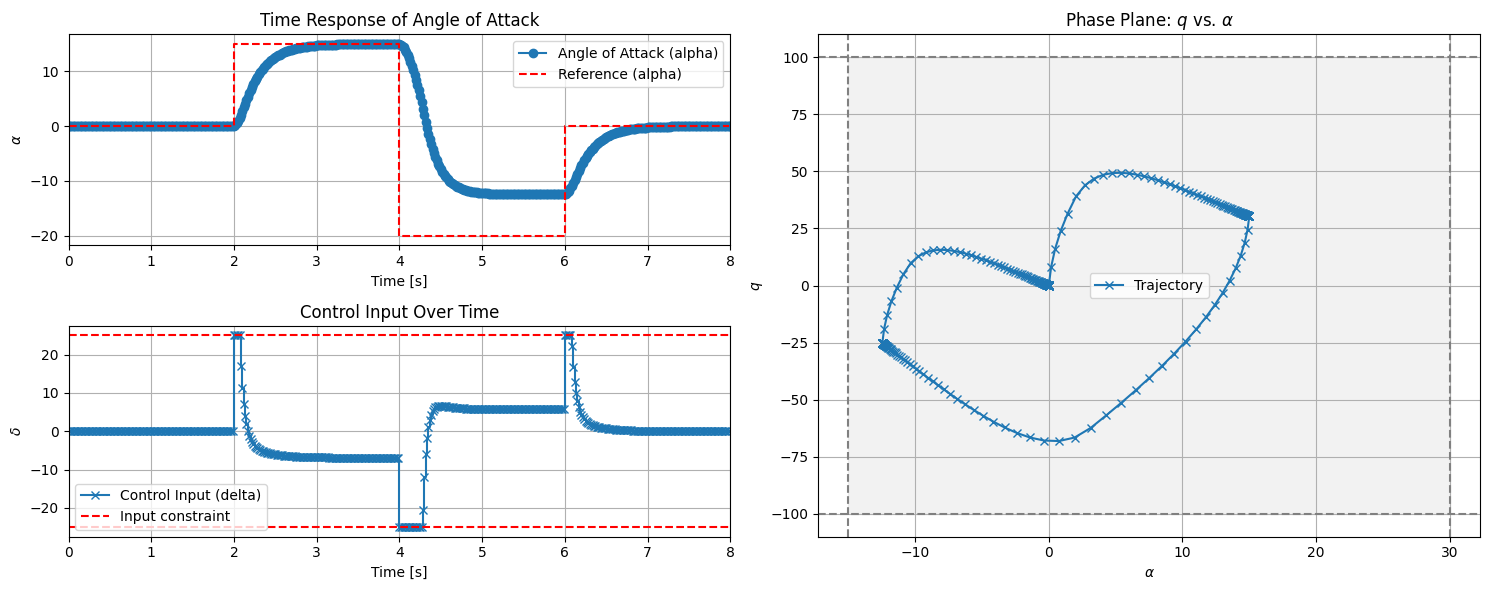

In [ ]:

# Define the discrete-time aircraft system
A = np.array([[0.9719, 0.0155], [0.2097, 0.9705]])
B = np.array([[0.0071], [0.3263]])
C = np.array([[1, 0]])  # Output matrix to pick only the first state (alpha)
D = np.zeros((1, 1))

# Create the state-space system (discrete-time)
sys_disc = LinearSystem(A, B, C, D)

# Define the cost matrices
Q = np.array([[10, 0], [0, 1]])  # State penalty
R = np.array([[1]])  # Input penalty
T = 10  # Prediction horizon

# Sampling time
sampling_time = 1 / 60  # 1/60 seconds

# Create the MPC parameters object
mpc_params = MPCParameters(system=sys_disc, horizon=T, Q=Q, R=R, QT=100*np.eye(2), solver='MOSEK')

# Add general state constraints for alpha and q: -15 <= alpha <= 30 and -100 <= q <= 100
Ax = np.array([
    [1, 0],   # alpha <= 30
    [-1, 0],  # alpha >= -15
    [0, 1],   # q <= 100
    [0, -1]   # q >= -100
])
bx = np.array([30, 15, 100, 100])
mpc_params.add_general_state_constraints(Ax, bx)

# Add input constraints: -25 <= delta <= 25
mpc_params.add_input_magnitude_constraint(limit=25)

# Soften the reference tracking constraint
mpc_params.soften_tracking_constraint(penalty_weight=10000)

# Add dual mode with an infinite-horizon LQR controller
L = sys_disc.get_lqr_controller(Q, R)  # Compute the infinite-horizon LQR controller
mpc_params.add_dual_mode(dual_mode_horizon=20, controller=L)

# Create the tracking MPC object
mpc_tracking = TrackingMPC(mpc_params)


# Run the simulation
T_sim_seconds = 8  # Total simulation time in seconds
T_sim = int(T_sim_seconds / sampling_time)  # Total simulation time in controller iterations
x0 = np.array([0, 0])  # Initial state

# Reference changes specified in absolute time (in seconds)
reference_values = [(0, 0), (2, 15.0), (4, -20.0), (6, 0)]  # Time (s) and reference pairs
reference_array = np.zeros(T_sim)  # Array to store the reference values (only alpha)
x_sim = np.zeros((2, T_sim + 1))
u_sim = np.zeros(T_sim)
x_sim[:, 0] = x0

# Simulation loop
for t in range(T_sim):
    current_state = x_sim[:, t]
    
    # Convert absolute time to simulation iterations
    current_time = t * sampling_time
    # Determine the current reference value based on the absolute time
    for time_sec, ref_value in reference_values:
        if current_time >= time_sec:
            current_reference = ref_value
    reference = np.array([current_reference])  # Tracking reference for alpha only

    # Store the current reference
    reference_array[t] = current_reference

    # Get the control action
    u_t = mpc_tracking.get_control_action(current_state, reference)
    u_sim[t] = u_t
    x_sim[:, t + 1] = A @ current_state + B @ u_t

# Plotting the simulation results
time = np.arange(T_sim + 1) * sampling_time  # Time vector in seconds for states
time_u = np.arange(T_sim) * sampling_time  # Time vector in seconds for control input

plt.figure(figsize=(15, 6))

# Plot alpha over time
plt.subplot(2, 2, 1)
plt.plot(time, x_sim[0, :], label='Angle of Attack (alpha)', marker='o')
plt.step(time_u, reference_array, where='post', linestyle='--', color='r', label='Reference (alpha)')
plt.xlabel('Time [s]')
plt.ylabel(r'$\alpha$')
plt.title('Time Response of Angle of Attack')
plt.legend()
plt.grid()
plt.xlim([0, T_sim_seconds])

# Plot control input delta over time
plt.subplot(2, 2, 3)
plt.step(time_u, u_sim, where='post', label='Control Input (delta)', marker='x')
plt.axhline(25, color='r', linestyle='--', label='Input constraint')
plt.axhline(-25, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\delta$')
plt.title('Control Input Over Time')
plt.legend()
plt.grid()
plt.xlim([0, T_sim_seconds])

# Plot phase plane (alpha vs. q)
plt.subplot(1, 2, 2)
plt.plot(x_sim[0, :], x_sim[1, :], marker='x', label='Trajectory')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$q$')
plt.title('Phase Plane: $q$ vs. $\\alpha$')
# Add state constraints as shaded region
plt.axhline(100, color='gray', linestyle='--')
plt.axhline(-100, color='gray', linestyle='--')
plt.axvline(30, color='gray', linestyle='--')
plt.axvline(-15, color='gray', linestyle='--')
plt.fill_betweenx(np.linspace(-100, 100, 100), -15, 30, color='gray', alpha=0.1)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
